In [ ]:
!pip install tensorflow


In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Directories for images and masks
image_directory = "D:\Sementic_Segmentation\Water Bodies Dataset\Images"
mask_directory = "D:\Sementic_Segmentation\Water Bodies Dataset\Masks"


# Resize size
SIZE = 128

# Create placeholders for images and masks
image_dataset = []
mask_dataset = []

# Load and process images
images = os.listdir(image_directory)
for i, image_name in enumerate(images):
    if image_name.split('.')[-1].lower() in ['jpg', 'jpeg', 'png']:
        # Read and process the image
        image = cv2.imread(os.path.join(image_directory, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

        # Construct the mask filename
        mask_name = image_name.replace('.jpg', '.png')  # Adjust based on actual naming
        mask_name = image_name.replace('.jpeg', '.png')
        mask_name = image_name.replace('.png', '.png')

        # Check if the mask file exists
        if os.path.exists(os.path.join(mask_directory, mask_name)):
            mask = cv2.imread(os.path.join(mask_directory, mask_name), cv2.IMREAD_GRAYSCALE)
            mask = Image.fromarray(mask)
            mask = mask.resize((SIZE, SIZE))
            mask_dataset.append(np.array(mask))
        else:
            print(f'Mask for {image_name} not found')





In [2]:
# Normalize images (scaling between 0 and 1)
# Convert lists to numpy arrays
image_dataset = np.array(image_dataset)/255.0
mask_dataset = np.array(mask_dataset)/255.0


In [3]:
print(len(mask_dataset))
print(len(image_dataset))

2841
2841


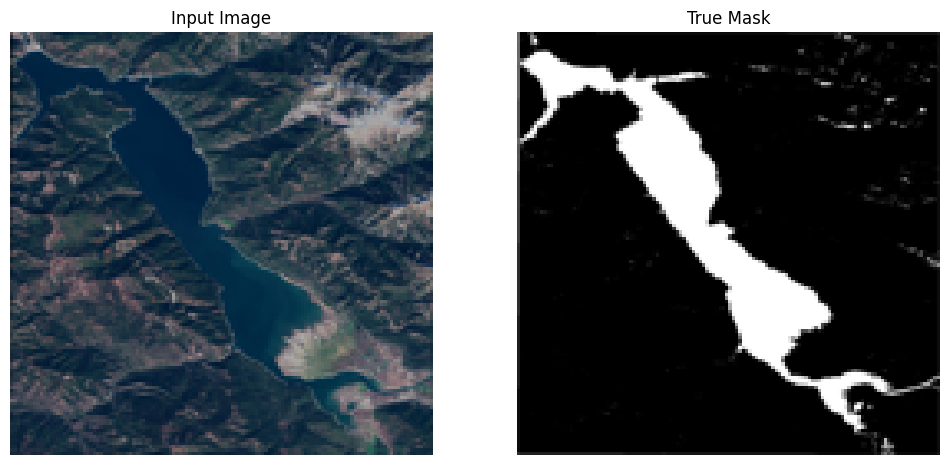

In [41]:
# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.10, random_state=42)

# Split the test set into validation (50%) and final test set (50%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

# Sanity check: Visualize a random training image and its corresponding mask
image_number = random.randint(0, len(X_train) - 1)

plt.figure(figsize=(12, 6))
# Visualize the image
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (SIZE, SIZE, 3)))  # RGB image
plt.title("Input Image")
plt.axis('off')

# Visualize the mask
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)), cmap='gray')  # Grayscale mask
plt.title("True Mask")
plt.axis('off')

plt.show()

# Now you have:
# X_train, y_train -> Training data and labels
# X_val, y_val -> Validation data and labels
# X_test, y_test -> Test data and labels

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Concatenate, Conv2DTranspose

@tf.function
def iou_Metric(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Define U-Net model
def encoder_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal')(inputs)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    p = MaxPool2D(pool_size=(2,2))(x)
    p = tf.keras.layers.Dropout(0.2)(p)
    return x,p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(inputs)
    # skip_features = tf.image.resize(skip_features, size =(x.shape[1], x.shape[2]))
    x = Concatenate()([x, skip_features])
    x = tf.keras.layers.Dropout(0.2)(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Activation('relu')(x)
    return x

def unet_model(input_shape = (128, 128, 3), num_classes=1):
    inputs = tf.keras.layers.Input(input_shape)

    x1,s1 = encoder_block(inputs, 32)
    x2,s2 = encoder_block(s1, 64)
    x3,s3 = encoder_block(s2, 128)
    # x4,s4 = encoder_block(s3, 256)

    b1 = Conv2D(256, 3, padding='same')(s3)
    b1 = Activation('relu')(b1)
    b1 = Conv2D(256, 3, padding='same')(b1)
    b1 = Activation('relu')(b1)

    # s5 = decoder_block(b1, x4, 256)
    s6 = decoder_block(b1, x3, 128)
    s7 = decoder_block(s6, x2, 64)
    s8 = decoder_block(s7, x1, 32)

    outputs = Conv2D(num_classes, 1, padding='same', activation='sigmoid')(s8)
    model = tf.keras.models.Model(inputs,outputs, name = 'U-Net')
    return model
if __name__ == '__main__':
    model = unet_model(input_shape=(128,128,3), num_classes=1)
    model.summary()

    # Compile the model
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    #               loss="binary_crossentropy",
    #               metrics=["accuracy"])
    from tensorflow.keras.metrics import MeanIoU

    iou_metric = MeanIoU(num_classes=2)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy", iou_metric])

    # Train the model
    # history = model.fit(X_train, y_train,
    #                 batch_size = 16,
    #                 verbose=1,
    #                 epochs=50,
    #                 validation_data=(X_val, y_val),
    #                 shuffle=False)


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 128, 128,  │          0 │ conv2d_38[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_28[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64, 64,    │          0 │ max_pooling2d_8[… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │     18,496 │ dropout_16[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 64, 64,    │          0 │ conv2d_40[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_29[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 32, 32,    │          0 │ max_pooling2d_9[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     73,856 │ dropout_17[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 32, 32,    │          0 │ conv2d_42[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │    147,584 │ activation_30[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 16, 16,    │          0 │ max_pooling2d_10… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │    295,168 │ dropout_18[0][0]

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

epochs = 80
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping, lr_reduce])

In [50]:
model.save('Binary_1_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


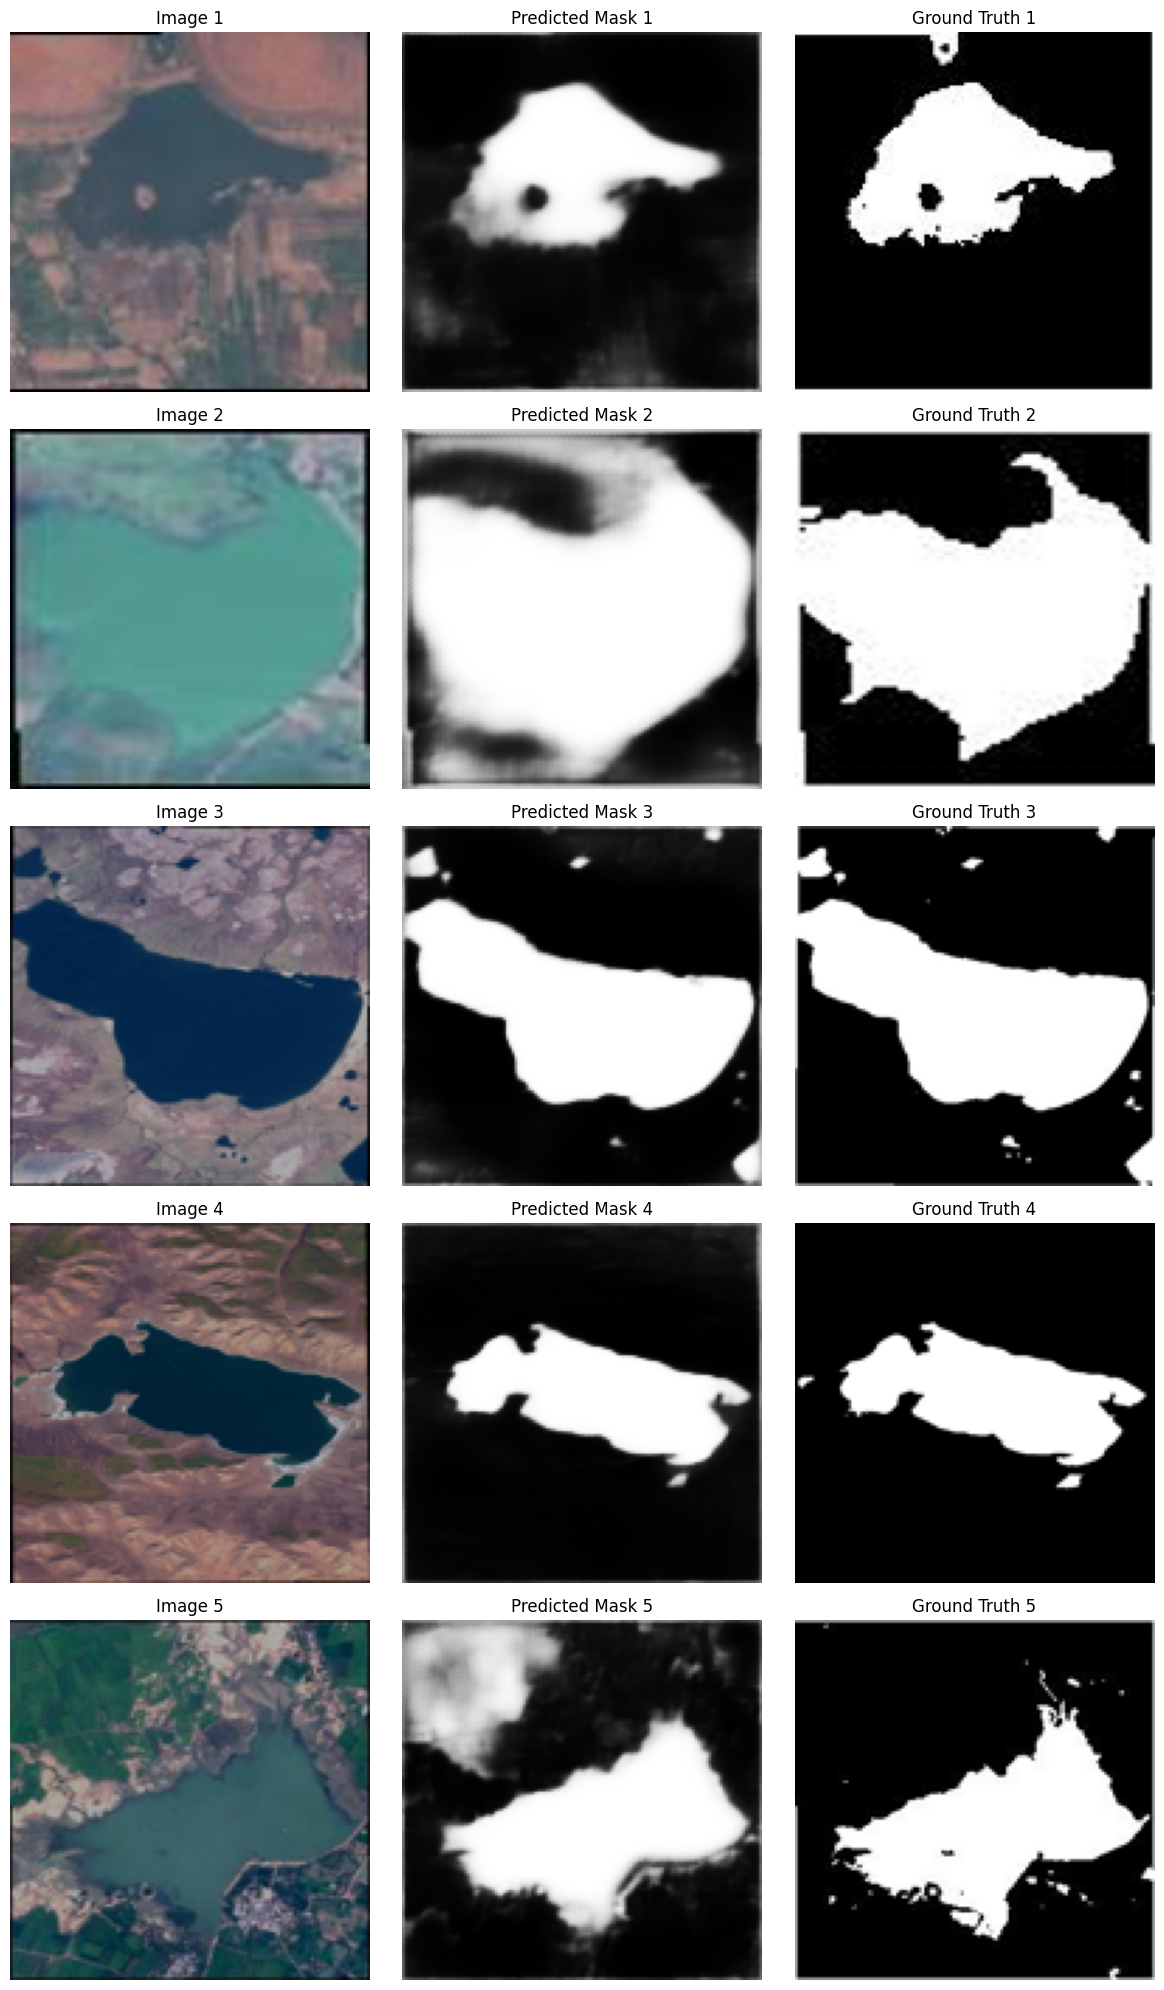

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already trained your model and have test data (X_test, y_test)
# For the sake of example, let's say we have 5 test samples
# You should replace X_test and y_test with your actual test set

# Predict on a few test examples (5 in this case)
predictions = model.predict(X_test[:5])

# Plot the results (image, predicted mask, and ground truth mask side by side)
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

for i in range(5):
    # Original Image
    axes[i, 0].imshow(X_test[i])  # Display the original image
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis('off')  # Hide axes

    # Predicted Mask
    axes[i, 1].imshow(predictions[i].squeeze(), cmap='gray')  # Display the predicted mask
    axes[i, 1].set_title(f"Predicted Mask {i+1}")
    axes[i, 1].axis('off')  # Hide axes

    # Ground Truth Mask
    axes[i, 2].imshow(y_test[i].squeeze(), cmap='gray')  # Display the ground truth mask
    axes[i, 2].set_title(f"Ground Truth {i+1}")
    axes[i, 2].axis('off')  # Hide axes

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


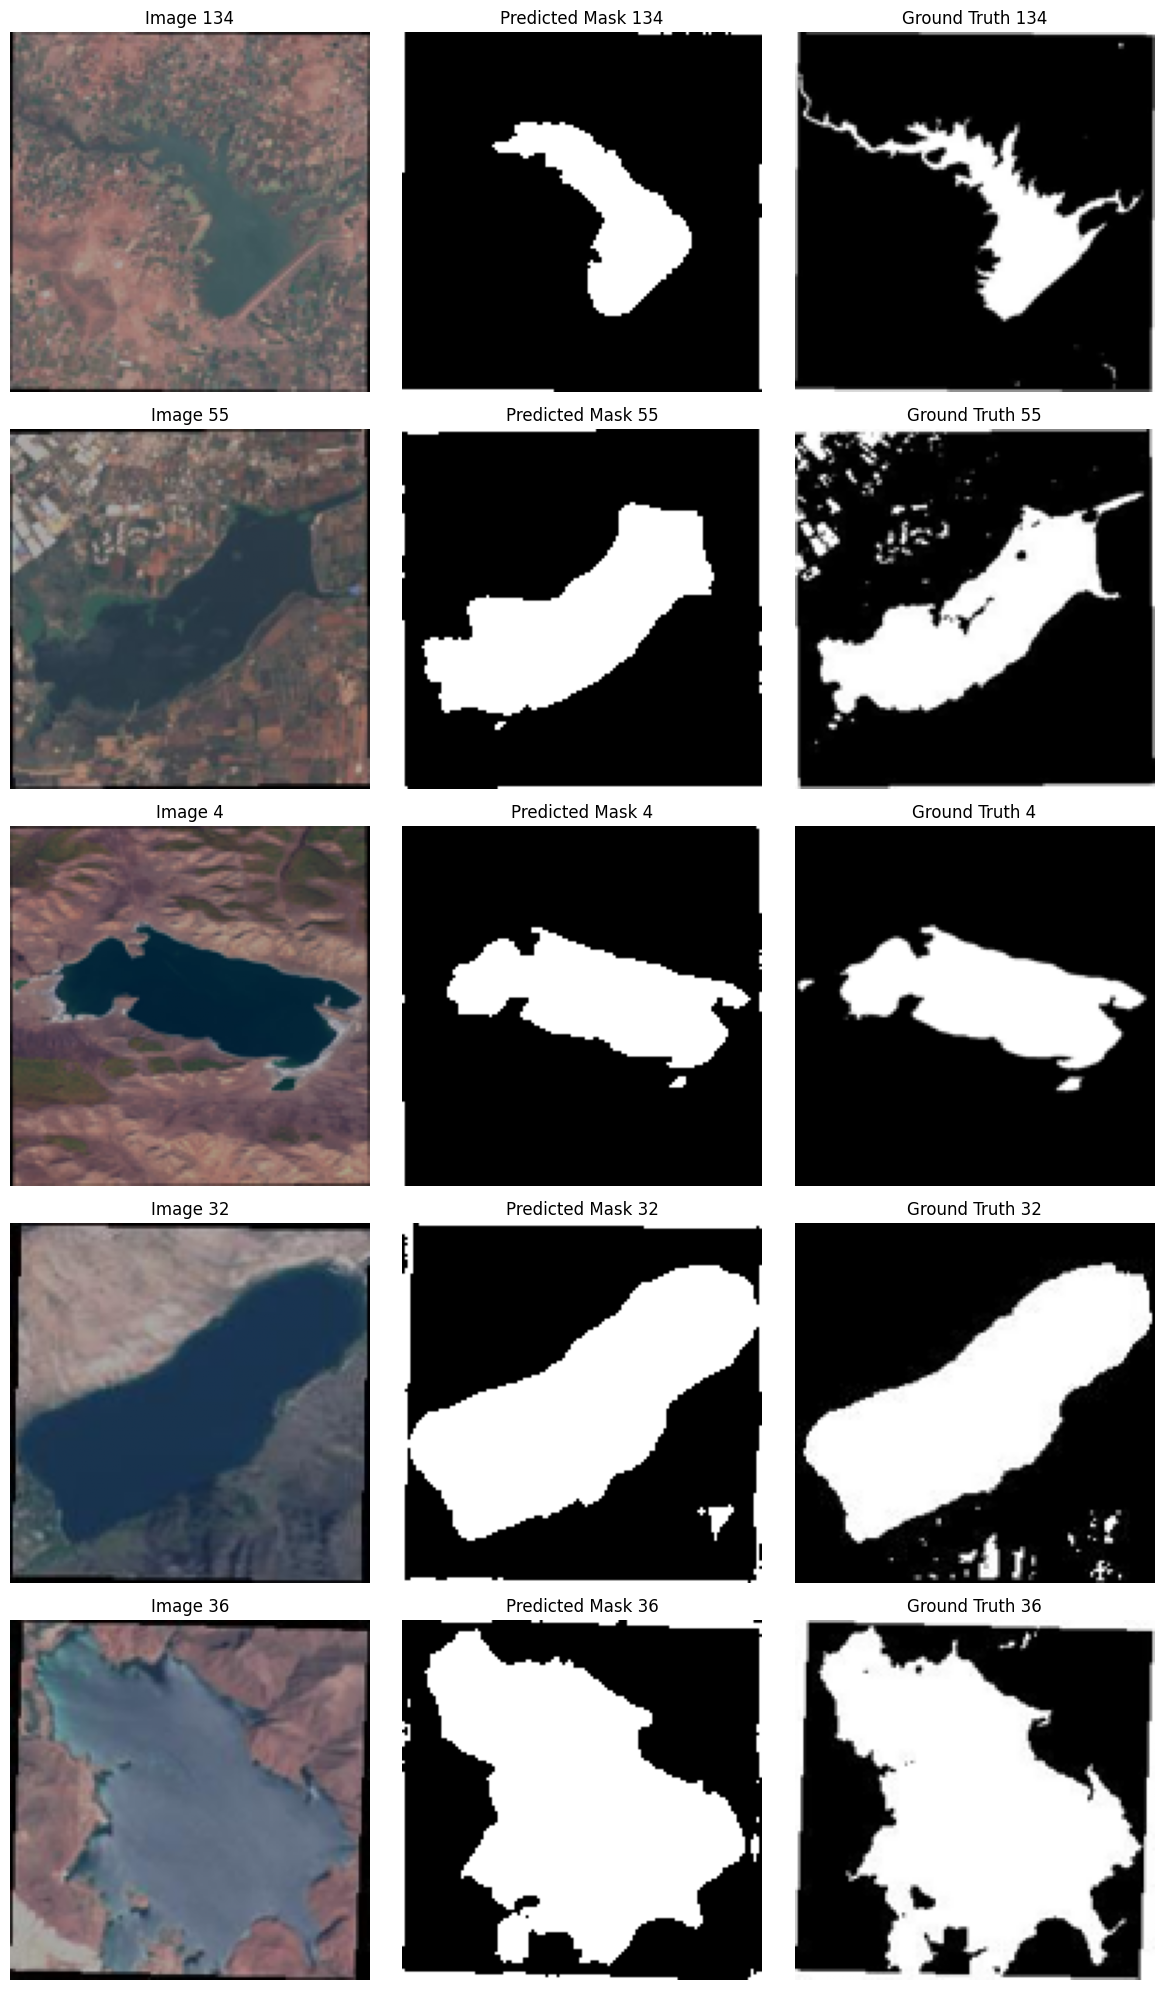

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples to display
num_samples = 5

# Select 5 random indices from the dataset
random_indices = np.random.choice(len(X_test), size=num_samples, replace=False)

# Predict on the randomly selected test examples
predictions = model.predict(X_test[random_indices])

# Apply threshold to predictions
binary_predictions = np.where(predictions >= 0.5, 1, 0)

# Plot the results (image, predicted mask, and ground truth mask side by side)
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

for idx, i in enumerate(random_indices):
    # Original Image
    axes[idx, 0].imshow(X_test[i])  # Display the original image
    axes[idx, 0].set_title(f"Image {i+1}")
    axes[idx, 0].axis('off')  # Hide axes

    # Predicted Mask (Binary)
    axes[idx, 1].imshow(binary_predictions[idx].squeeze(), cmap='gray')  # Display the binary predicted mask
    axes[idx, 1].set_title(f"Predicted Mask {i+1}")
    axes[idx, 1].axis('off')  # Hide axes

    # Ground Truth Mask
    axes[idx, 2].imshow(y_test[i].squeeze(), cmap='gray')  # Display the ground truth mask
    axes[idx, 2].set_title(f"Ground Truth {i+1}")
    axes[idx, 2].axis('off')  # Hide axes

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


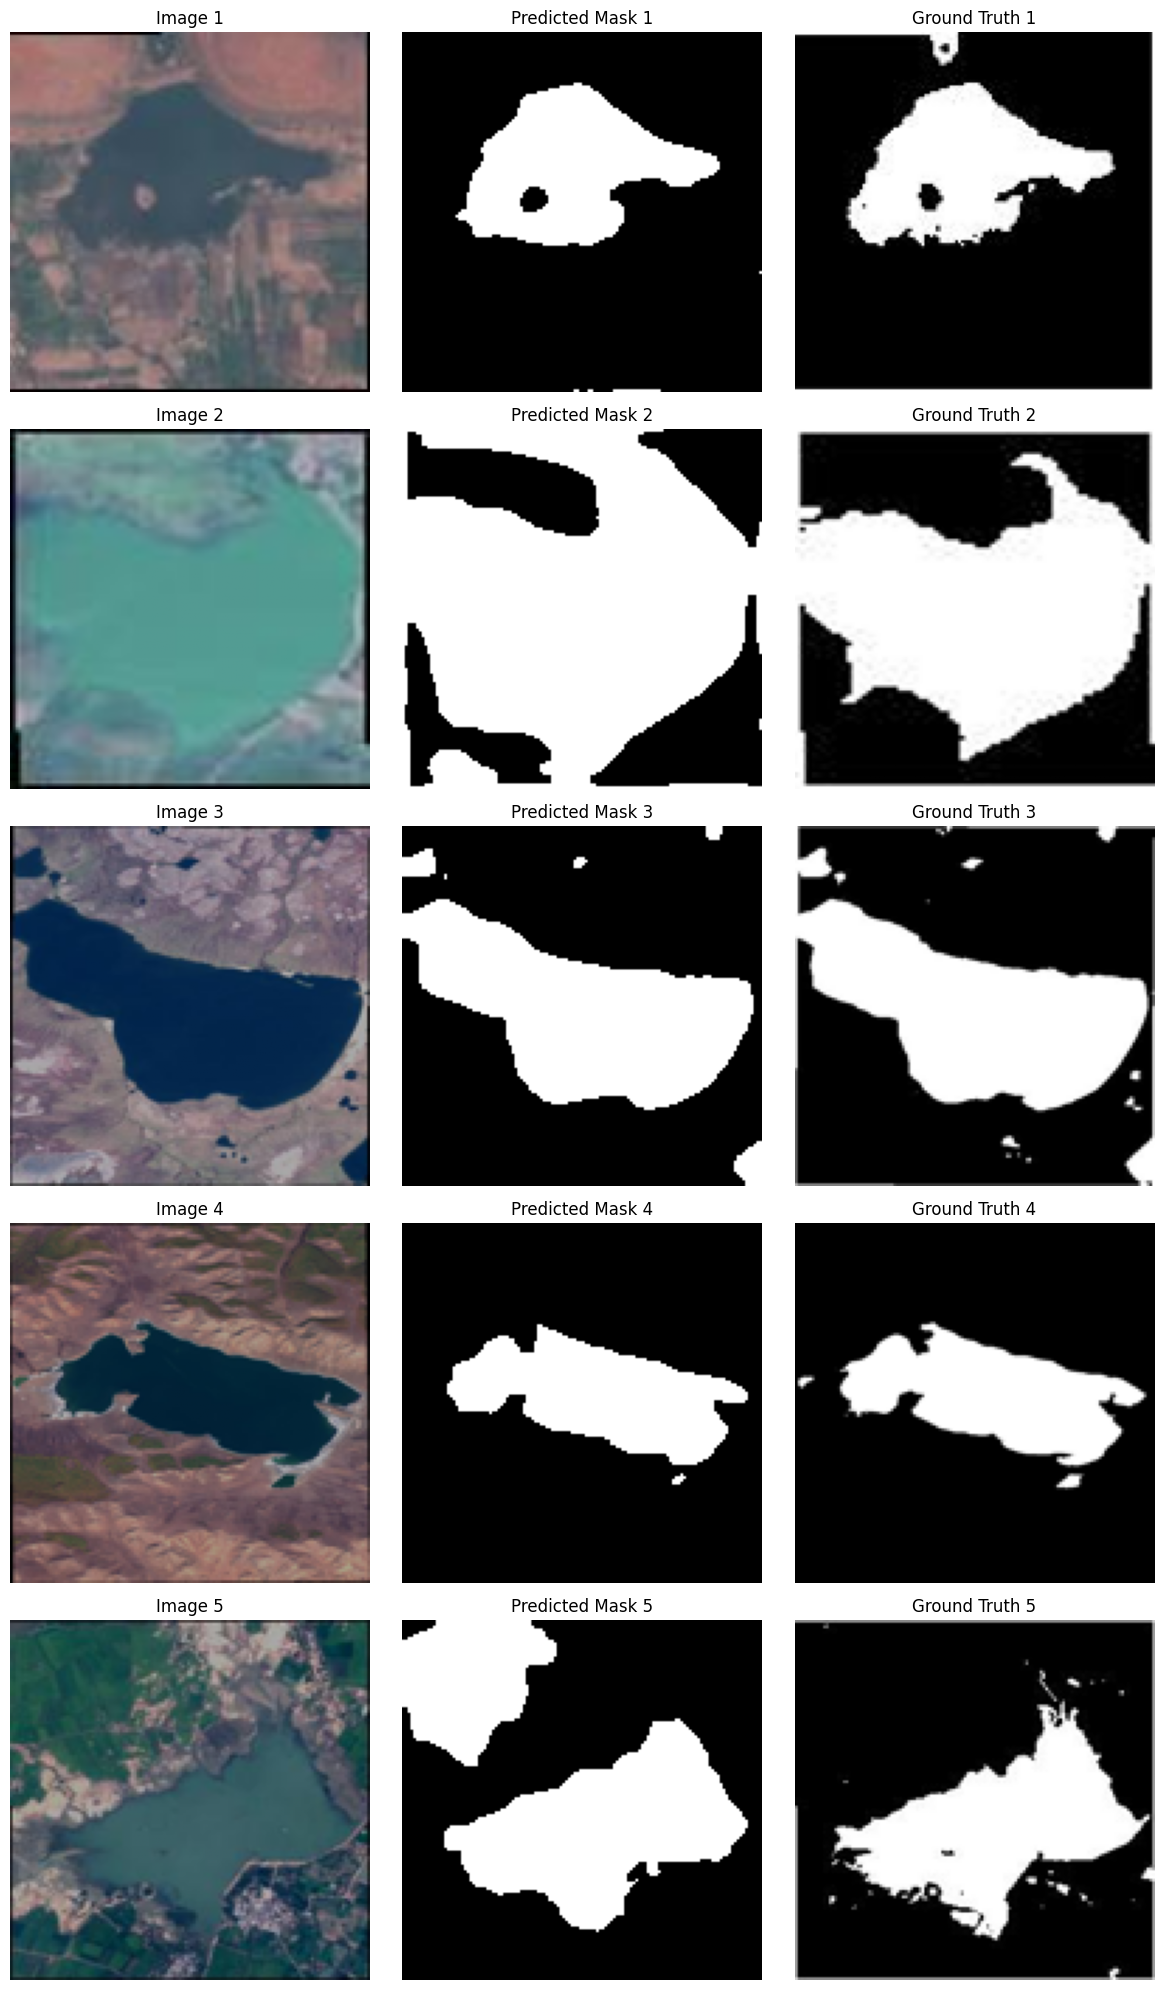

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Predict on a few test examples (5 in this case)
predictions = model.predict(X_test[:5])

# Apply Gaussian blur and threshold
blurred_predictions = np.array([cv2.GaussianBlur(pred.squeeze(), (5, 5), 0) for pred in predictions])
binary_predictions = np.where(blurred_predictions >= 0.5, 1, 0)

# Apply morphological closing
kernel = np.ones((3, 3), np.uint8)
binary_predictions = np.array([
    cv2.morphologyEx(pred.astype(np.uint8), cv2.MORPH_CLOSE, kernel) for pred in binary_predictions
])

# Plot the results
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

for i in range(5):
    axes[i, 0].imshow(X_test[i])
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(binary_predictions[i], cmap='gray')
    axes[i, 1].set_title(f"Predicted Mask {i+1}")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(y_test[i].squeeze(), cmap='gray')
    axes[i, 2].set_title(f"Ground Truth {i+1}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


In [53]:
import numpy as np

def calculate_iou(y_true, y_pred):
    """
    Calculate IoU for binary masks.

    Parameters:
    - y_true: Ground truth mask (binary, shape: HxW or NxHxW).
    - y_pred: Predicted mask (binary, same shape as y_true).

    Returns:
    - iou: Intersection over Union value.
    """
    intersection = np.logical_and(y_true, y_pred).sum()  # Area of overlap
    union = np.logical_or(y_true, y_pred).sum()  # Area of combined region

    if union == 0:  # Avoid division by zero
        return 0.0

    iou = intersection / union
    return iou

# Calculate IoU for each test sample
ious = []
for i in range(len(binary_predictions)):
    iou = calculate_iou(y_test[i].squeeze(), binary_predictions[i].squeeze())
    ious.append(iou)

# Average IoU over the dataset
average_iou = np.mean(ious)
print(f"Average IoU: {average_iou:.4f}")


Average IoU: 0.7045
